- understand matplotlib fig and ax
- group stuff like a, b, nextA into class

## Imports

In [3]:
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

import shapely.geometry as geom
import shapely.affinity as aff
import shapely.ops

# Rolling one polygon around another

## Plotting geometries

In [4]:
def plotCoords(coords, axes):
    x,y = zip(*list(coords))
    axes.plot(x,y)

def plotPoints(points, axes):
    x,y = zip(*list(points))
    axes.scatter(x, y)

def plotPolys(polys, axes):
    for poly in polys:
        if not getattr(poly, "exterior", None):
            print("got line?")

        plotCoords(poly.exterior.coords, axes)

        for hole in poly.interiors:
            plotCoords(hole.coords, axes)

## Generating a regular polygon

In [5]:
def makePoly(sides, radius):
    line = geom.LineString([(0, 0), (0, radius)])
    vertices = []

    if sides % 2 == 0:
        line = aff.rotate(line, -360 / sides / 2, origin=(0, 0))

    for i in range(0, sides):
        line = geom.LineString([*line.coords])
        vertices.append(line.coords[1])
        line = aff.rotate(line, -360 / sides, origin=(0, 0))

    return geom.Polygon(vertices)

## Finding and rotating by the angle needed for rolling

In [164]:
def angleFinder(a, b, nextA, nextB, tracingPoint, result, accuracy):
    aAngle = (len(a.exterior.coords) - 3) * 180 / (len(a.exterior.coords) - 1)
    if touches(nextA[0], b):
        if nextB[0].__eq__(nextA[0]):
            # on edge
            angle = 360 - aAngle - bAngle
            nextB[1] = changePoint(nextB[1], b, -1)
        else:
            # over edge
            angle = 180 - aAngle
        rotationPoint = list(nextA[0].coords)
        nextA[1] = changePoint(nextA[1], a, 1)
    else:
        # behind edge
        bAngle = (len(b.exterior.coords) - 3) * 180 / (len(b.exterior.coords) - 1)
        angle = 180 - bAngle
        rotationPoint = list(nextB[0].coords)
        nextB[1] = changePoint(nextB[1], b, -1)
    nextA[0] = extractPoint(nextA[1], a)
    nextB[0] = extractPoint(nextB[1], b)

    b, tracingPoint, result = animRotate(b, angle, *rotationPoint, tracingPoint, result, accuracy)
    print(b.exterior.coords[len(b.exterior.coords) - 1])
    
    return b, nextA, nextB, tracingPoint, result

## Miscellaneous and small functions

In [7]:
def touches(point, poly):
    return geom.LineString(poly.exterior.coords).distance(point) < 0.00000000001

def extractPoint(index, poly):
    return geom.Point(poly.exterior.coords[index])

def changePoint(index, poly, direction):
    if index == 0 and direction == -1:
        return len(poly.exterior.coords) - 2
    elif index == len(poly.exterior.coords) - 2 and direction == 1:
        return 0
    else:
        return index + direction

# Creating the resultant path

In [165]:
def animRotate(poly, angle, rotationPoint, tracingPoint, result, accuracy):
    # i know this is stupid but its finneeeeeeeeeeeeee, the alternative is a class which wouldnt be that much cleaner

    # angle is negative for clockwise, accuracy is the number of degrees between recording position
    for i in range(int((angle) // accuracy)):
        poly = aff.rotate(poly, -accuracy, origin=rotationPoint)
        tracingPoint = aff.rotate(tracingPoint, -accuracy, origin=rotationPoint)

        result.append(*list(tracingPoint.coords))

    angleLeftOver = angle - accuracy * int(angle // accuracy)
    poly = aff.rotate(poly, -angleLeftOver, origin=rotationPoint)
    tracingPoint = aff.rotate(tracingPoint, -angleLeftOver, origin=rotationPoint)
    result.append(*list(tracingPoint.coords))
    
    return poly, tracingPoint, result

# Animation

# Testing

In [170]:
a = makePoly(4, 1)
b = makePoly(3, 1)
tracingPoint = geom.Point(b.centroid.coords[0][0], b.bounds[3])
result = [*list(tracingPoint.coords)]

b = aff.translate(b, yoff=abs(a.bounds[3]) + abs(b.bounds[1]))

## Initial rotation

In [171]:
nextA = [extractPoint((len(a.exterior.coords) - 2) // 2, a), (len(a.exterior.coords) - 2) // 2]
nextB = [extractPoint((len(b.exterior.coords) - 2) // 2, b), (len(b.exterior.coords) - 2) // 2]
aAngle = (len(a.exterior.coords) - 3) * 180 / (len(a.exterior.coords) - 1)

if (len(a.exterior.coords) - 1) % 2 == 1:
    # special case
    b = aff.rotate(b, -(180 - aAngle) / 2, origin=a.exterior.coords[0])
    nextA[1] = 1
elif touches(extractPoint(0, a), b):
    if nextB[0].__eq__(nextA[0]):
        # on edge
        b = aff.rotate(b, -(360 - aAngle - bAngle), origin=a.exterior.coords[0])
        nextB[1] = (nextB[1] - 1) % len(b.exterior.coords)
    else:
        # over edge
        b = aff.rotate(b, -(180 - aAngle), origin=a.exterior.coords[0])
    nextA[1] = 1
else:
    # behind edge
    bAngle = (len(b.exterior.coords) - 3) * 180 / (len(b.exterior.coords) - 1)
    b = aff.rotate(b, -(180 - bAngle), *nextB[0].coords)
    nextA[1] = 1

nextA[0] = extractPoint(nextA[1], a)
nextB[0] = extractPoint(nextB[1], b)

## Continuous rotation

In [172]:
for i in range(0, 0):
    b, nextA, nextB, tracingPoint, result = angleFinder(a, b, nextA, nextB, tracingPoint, result, 10)

## Plotting

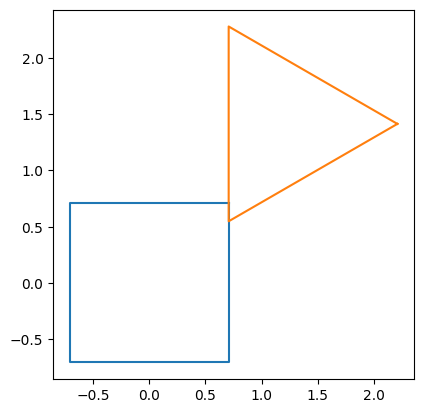

In [173]:
fig, axes = plt.subplots(1, 1)
axes.axes.set_aspect("equal")
plotPolys([a, b], axes)

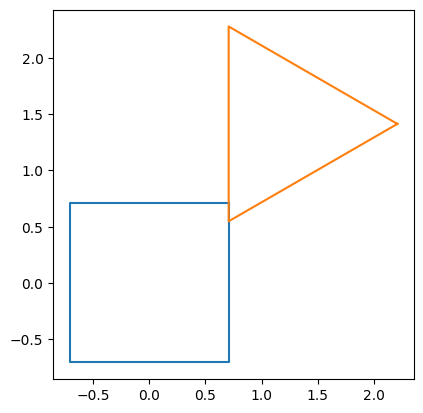

## Pictures 1

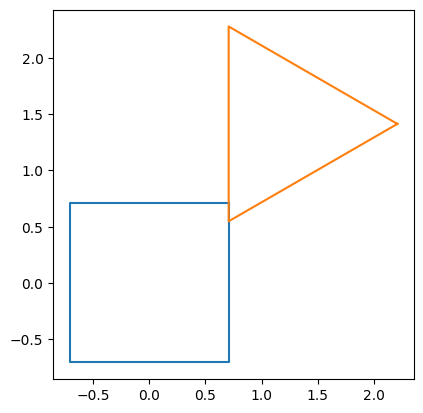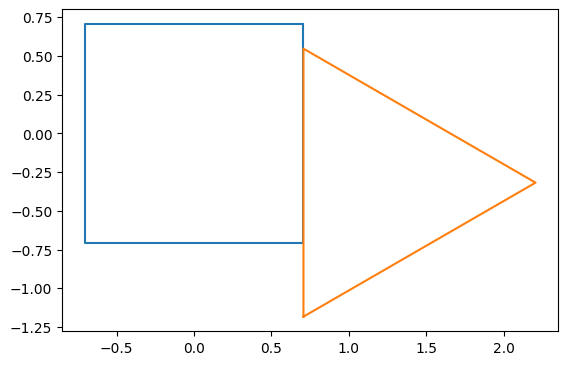 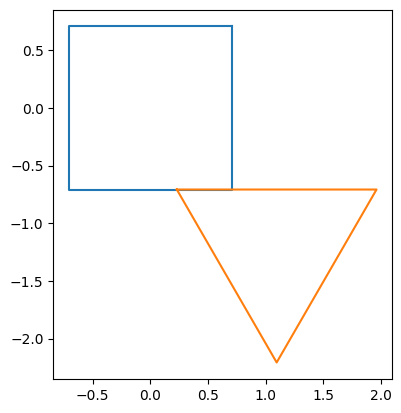 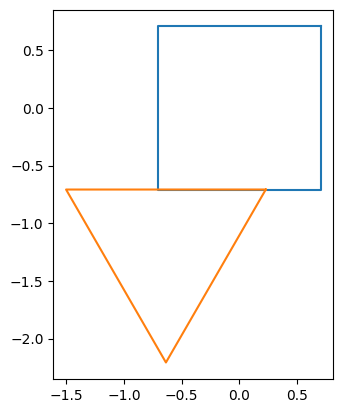 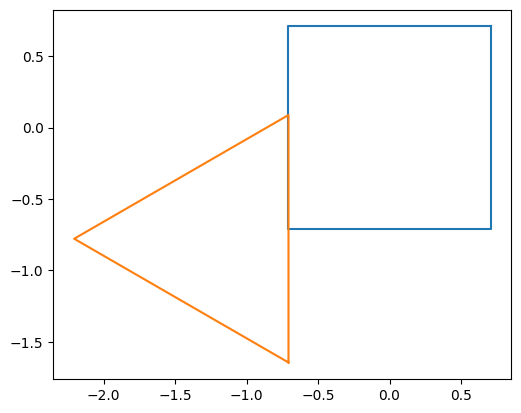

## States after rotation

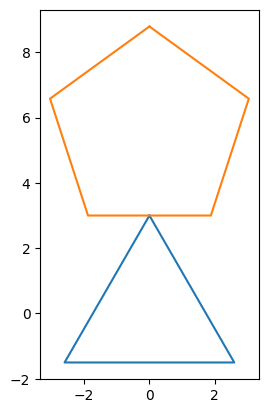 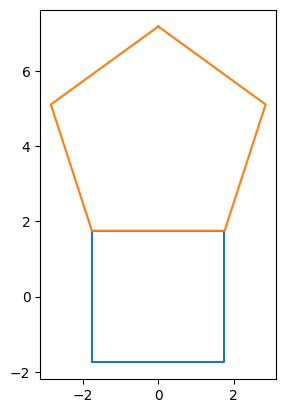 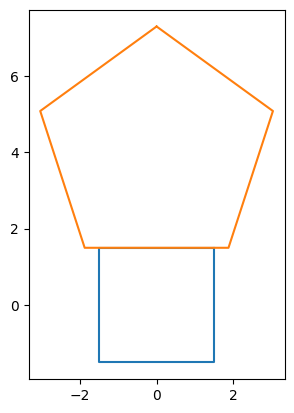 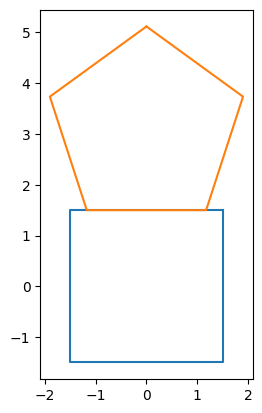